In [2]:
df <- read.csv("/kaggle/input/insurance-data-new/model_data_(2).csv")
eval_data <- read.csv("/kaggle/input/insurance-data-new/eval_data_(2).csv")

In [10]:
summary(df)

    charges        children_0       children_1       children_2    
 Min.   : 1122   Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.: 4773   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median : 9382   Median :0.0000   Median :0.0000   Median :0.0000  
 Mean   :13242   Mean   :0.4327   Mean   :0.2346   Mean   :0.1794  
 3rd Qu.:16546   3rd Qu.:1.0000   3rd Qu.:0.0000   3rd Qu.:0.0000  
 Max.   :63770   Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  
   children_3       children_4        children_5      region_northeast
 Min.   :0.0000   Min.   :0.00000   Min.   :0.00000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.00000   1st Qu.:0.00000   1st Qu.:0.0000  
 Median :0.0000   Median :0.00000   Median :0.00000   Median :0.0000  
 Mean   :0.1224   Mean   :0.01776   Mean   :0.01308   Mean   :0.2449  
 3rd Qu.:0.0000   3rd Qu.:0.00000   3rd Qu.:0.00000   3rd Qu.:0.0000  
 Max.   :1.0000   Max.   :1.00000   Max.   :1.00000   Max.   :1.0000  
 region_northwest region_so

In [11]:
# Install and load necessary packages
if (!requireNamespace("xgboost", quietly = TRUE)) install.packages("xgboost")
if (!requireNamespace("rBayesianOptimization", quietly = TRUE)) install.packages("rBayesianOptimization")
if (!requireNamespace("data.table", quietly = TRUE)) install.packages("data.table")

In [12]:
library(xgboost)
library(rBayesianOptimization)
library(data.table)

# Prepare DMatrix for xgboost
dtrain <- xgb.DMatrix(data = as.matrix(df[, -which(names(df) == "charges")]), label = df$charges)
deval <- xgb.DMatrix(data = as.matrix(eval_data[, -which(names(eval_data) == "charges")]), label = eval_data$charges)

# Define Bayesian Optimization function for tuning
bayes_tuning <- function(eta, max_depth, min_child_weight, subsample, colsample_bytree, gamma, tweedie_variance_power) {
  params <- list(
    objective = "reg:tweedie",
    tweedie_variance_power = tweedie_variance_power,
    eta = eta,
    max_depth = as.integer(max_depth),
    min_child_weight = min_child_weight,
    subsample = subsample,
    colsample_bytree = colsample_bytree,
    gamma = gamma,
    eval_metric = "rmse"
  )

  cv <- xgb.cv(
    params = params,
    data = dtrain,
    nrounds = 100,
    nfold = 5,
    verbose = 0,
    prediction = TRUE,
    early_stopping_rounds = 10
  )

  list(Score = -min(cv$evaluation_log$test_rmse_mean), Pred = cv$pred)
}

# Define bounds for hyperparameter tuning
bounds <- list(
  eta = c(0.05, 0.3),
  max_depth = c(3, 10),
  min_child_weight = c(1, 10),
  subsample = c(0.5, 1.0),
  colsample_bytree = c(0.5, 1.0),
  gamma = c(0, 5),
  tweedie_variance_power = c(1.1,1.999)  # Tweedie distribution power range
)

# Initialize a data frame to store the best parameters from each run
best_params <- data.frame()

# Perform Bayesian optimization for 5 runs
for(i in 1:5) {
  opt_results <- BayesianOptimization(
    FUN = bayes_tuning,
    bounds = bounds,
    init_points = 10,
    n_iter = 50,
    acq = "ucb",  # Upper Confidence Bound acquisition function
    kappa = 2.576,  # Exploration-exploitation parameter
    eps = 0.0,
    verbose = TRUE
  )

  # Retrieve best hyperparameters and store in the data frame
  best_params <- rbind(best_params, data.frame(run = i, t(opt_results$Best_Par)))
}

# Write the best parameters to a CSV file
write.csv(best_params, file = "best_params.csv", row.names = FALSE)

elapsed = 0.225	Round = 1	eta = 0.1990775	max_depth = 4.173441	min_child_weight = 3.415498	subsample = 0.8092337	colsample_bytree = 0.7158836	gamma = 4.591129	tweedie_variance_power = 1.194749	Value = -4897.7077 
elapsed = 0.40	Round = 2	eta = 0.1475962	max_depth = 4.071748	min_child_weight = 2.837953	subsample = 0.7860416	colsample_bytree = 0.7907763	gamma = 0.5425464	tweedie_variance_power = 1.494281	Value = -4740.9795 
elapsed = 0.888	Round = 3	eta = 0.2338185	max_depth = 9.204571	min_child_weight = 5.977224	subsample = 0.6742131	colsample_bytree = 0.6628416	gamma = 3.31576	tweedie_variance_power = 1.803793	Value = -5218.2500 
elapsed = 0.222	Round = 4	eta = 0.2823547	max_depth = 3.471311	min_child_weight = 7.479842	subsample = 0.70137	colsample_bytree = 0.7502485	gamma = 4.846936	tweedie_variance_power = 1.685259	Value = -4756.8471 
elapsed = 0.571	Round = 5	eta = 0.1386068	max_depth = 6.493134	min_child_weight = 3.096515	subsample = 0.9391717	colsample_bytree = 0.6087061	gamma = 4

Warning message:
“did not converge in 10 iterations”


elapsed = 0.388	Round = 25	eta = 0.2458153	max_depth = 3.531759	min_child_weight = 1.0000	subsample = 1.0000	colsample_bytree = 0.9918543	gamma = 1.003498	tweedie_variance_power = 1.9990	Value = -4811.9677 
elapsed = 0.148	Round = 26	eta = 0.2629088	max_depth = 4.616843	min_child_weight = 2.010606	subsample = 0.9834868	colsample_bytree = 0.9309289	gamma = 2.732842	tweedie_variance_power = 1.1000	Value = -4960.1634 
elapsed = 1.025	Round = 27	eta = 0.2089665	max_depth = 10.0000	min_child_weight = 1.0000	subsample = 0.5000	colsample_bytree = 0.9078592	gamma = 1.642075	tweedie_variance_power = 1.880902	Value = -4850.5776 
elapsed = 0.389	Round = 28	eta = 0.2084288	max_depth = 3.0000	min_child_weight = 9.689198	subsample = 0.968986	colsample_bytree = 0.7996579	gamma = 4.470468	tweedie_variance_power = 1.9990	Value = -5568.7413 
elapsed = 0.968	Round = 29	eta = 0.3000	max_depth = 10.0000	min_child_weight = 6.880309	subsample = 1.0000	colsample_bytree = 0.8574425	gamma = 4.364966	tweedie_var

Warning message:
“did not converge in 10 iterations”


elapsed = 0.224	Round = 34	eta = 0.2665576	max_depth = 3.981172	min_child_weight = 1.0000	subsample = 0.5000	colsample_bytree = 1.0000	gamma = 2.776376	tweedie_variance_power = 1.823573	Value = -4799.6084 
elapsed = 0.197	Round = 35	eta = 0.3000	max_depth = 3.270513	min_child_weight = 10.0000	subsample = 0.9278052	colsample_bytree = 0.5000	gamma = 0.8704742	tweedie_variance_power = 1.781872	Value = -4846.8605 
elapsed = 0.283	Round = 36	eta = 0.1919396	max_depth = 5.989325	min_child_weight = 1.0000	subsample = 0.7103443	colsample_bytree = 1.0000	gamma = 3.902084	tweedie_variance_power = 1.367875	Value = -4716.1284 
elapsed = 0.10	Round = 37	eta = 0.2872026	max_depth = 3.553679	min_child_weight = 8.904043	subsample = 0.5000	colsample_bytree = 1.0000	gamma = 4.441021	tweedie_variance_power = 1.1000	Value = -4958.9278 
elapsed = 0.208	Round = 38	eta = 0.1840468	max_depth = 4.049245	min_child_weight = 2.891718	subsample = 1.0000	colsample_bytree = 0.5000	gamma = 1.968134	tweedie_variance_p

Warning message:
“did not converge in 10 iterations”


elapsed = 0.49	Round = 53	eta = 0.156128	max_depth = 5.292923	min_child_weight = 1.0000	subsample = 0.9140846	colsample_bytree = 1.0000	gamma = 5.0000	tweedie_variance_power = 1.792415	Value = -4708.1854 
elapsed = 0.167	Round = 54	eta = 0.2527492	max_depth = 3.237373	min_child_weight = 9.946328	subsample = 0.9571812	colsample_bytree = 0.7496705	gamma = 3.019011	tweedie_variance_power = 1.38006	Value = -4659.3338 
elapsed = 0.556	Round = 55	eta = 0.08343449	max_depth = 5.997232	min_child_weight = 6.394375	subsample = 0.5529629	colsample_bytree = 0.8462353	gamma = 1.893622	tweedie_variance_power = 1.445816	Value = -4921.6517 
elapsed = 1.436	Round = 56	eta = 0.1891919	max_depth = 6.296559	min_child_weight = 5.445768	subsample = 0.5887097	colsample_bytree = 0.609188	gamma = 3.979609	tweedie_variance_power = 1.298814	Value = -5316.2625 
elapsed = 0.274	Round = 57	eta = 0.0500021	max_depth = 9.999975	min_child_weight = 6.668679	subsample = 0.5000	colsample_bytree = 1.0000	gamma = 4.999982	

Warning message:
“did not converge in 10 iterations”


elapsed = 0.815	Round = 31	eta = 0.1171057	max_depth = 9.710697	min_child_weight = 1.116006	subsample = 0.6720125	colsample_bytree = 0.5000	gamma = 4.576297	tweedie_variance_power = 1.665323	Value = -6374.9195 
elapsed = 0.747	Round = 32	eta = 0.06401545	max_depth = 6.113415	min_child_weight = 2.713599	subsample = 0.8342892	colsample_bytree = 0.9971098	gamma = 4.347357	tweedie_variance_power = 1.182253	Value = -4814.4718 
elapsed = 0.326	Round = 33	eta = 0.3000	max_depth = 8.205972	min_child_weight = 1.0000	subsample = 0.8886018	colsample_bytree = 0.5000	gamma = 2.220446e-16	tweedie_variance_power = 1.1000	Value = -7457.6390 
elapsed = 0.208	Round = 34	eta = 0.100989	max_depth = 3.0000	min_child_weight = 10.0000	subsample = 0.5168054	colsample_bytree = 1.0000	gamma = 2.220446e-16	tweedie_variance_power = 1.1000	Value = -4574.3461 
elapsed = 1.278	Round = 35	eta = 0.05733012	max_depth = 9.434858	min_child_weight = 10.0000	subsample = 0.718775	colsample_bytree = 0.5000	gamma = 2.220446e-

Warning message:
“did not converge in 10 iterations”


elapsed = 0.223	Round = 29	eta = 0.2649137	max_depth = 3.0000	min_child_weight = 10.0000	subsample = 1.0000	colsample_bytree = 0.5225002	gamma = 2.220446e-16	tweedie_variance_power = 1.727411	Value = -5047.9578 
elapsed = 0.125	Round = 30	eta = 0.2243607	max_depth = 3.0000	min_child_weight = 1.560618	subsample = 1.0000	colsample_bytree = 0.5000	gamma = 5.0000	tweedie_variance_power = 1.1000	Value = -4760.6416 
elapsed = 0.146	Round = 31	eta = 0.3000	max_depth = 3.0000	min_child_weight = 1.451122	subsample = 1.0000	colsample_bytree = 0.5000	gamma = 2.220446e-16	tweedie_variance_power = 1.276893	Value = -4965.7796 
elapsed = 0.255	Round = 32	eta = 0.1397459	max_depth = 3.0000	min_child_weight = 1.667043	subsample = 0.5000	colsample_bytree = 1.0000	gamma = 2.220446e-16	tweedie_variance_power = 1.406299	Value = -4639.9122 
elapsed = 0.282	Round = 33	eta = 0.1667659	max_depth = 3.0000	min_child_weight = 8.90279	subsample = 0.5000	colsample_bytree = 1.0000	gamma = 5.0000	tweedie_variance_pow

In [12]:
library(xgboost)
library(rBayesianOptimization)
library(data.table)

# Prepare DMatrix for xgboost
dtrain <- xgb.DMatrix(data = as.matrix(df[, -which(names(df) == "charges")]), label = df$charges)
deval <- xgb.DMatrix(data = as.matrix(eval_data[, -which(names(eval_data) == "charges")]), label = eval_data$charges)
# Load the best parameters from the CSV file
best_params <- read.csv("/kaggle/input/best-parameters/best_params.csv")

# Convert the rows of the data frame 'best_params' to a list of parameter sets
best_params_list <- apply(best_params, 1, function(x) {
  params <- as.list(x)
  # Convert 'max_depth' to integer
  params$max_depth <- as.integer(params$max_depth)
  # Remove the 'run' parameter
  params$run <- NULL
  params$objective <- "reg:tweedie"  # Set the objective
  return(params)
})

# Initialize a list to store RMSE for each run
rmse_list <- vector("list", 5)

# Initialize a list to store models from each run
models <- vector("list", 5)

# Initialize a list to store predictions from each run
preds_list <- vector("list", 5)

# Number of rounds for training
nrounds <- 100

# Train the XGBoost model with the best parameters 5 times
for (j in 1:5) {
  # Retrieve the best parameters for this run
  best_params <- best_params_list[[j]]

  # Initialize a vector to store RMSE for each inner run
  rmse <- rep(0, 5)

  # Inner loop to train the model 5 times with the same parameters
  for (i in 1:5) {
    # Train the model with the best parameters
    xgb_model <- xgb.train(params = best_params, data = dtrain, nrounds = nrounds)
    
    # Use the trained model to make predictions on the evaluation data
    preds <- predict(xgb_model, newdata = deval)
    
    # Compute the RMSE for this run
    rmse[i] <- sqrt(mean((eval_data$charges - preds)^2))
    
    # Print the RMSE for this run
    print(paste("RMSE for run", i, "of outer run", j, ":", rmse[i]))
    
    # Store the RMSE, model, and predictions
    rmse_list[[j]] <- rmse
    models[[j]] <- xgb_model
    preds_list[[j]] <- preds
  }

  # Compute the mean RMSE
  mean_rmse <- mean(rmse)

  # Compute the standard deviation of RMSE
  std_dev_rmse <- sd(rmse)

  # Print the mean RMSE and standard deviation of RMSE
  print(paste("Mean RMSE for outer run", j, ":", mean_rmse))
  print(paste("Standard deviation of RMSE for outer run", j, ":", std_dev_rmse))
}

# Find the model with the lowest mean RMSE
mean_rmses <- sapply(rmse_list, mean)
best_model_index <- which.min(mean_rmses)
best_model <- models[[best_model_index]]
best_preds <- preds_list[[best_model_index]]

# Print the RMSE of the best model
print(paste("RMSE of the best model:", mean_rmses[best_model_index]))

[1] "RMSE for run 1 of outer run 1 : 4669.6012251554"
[1] "RMSE for run 2 of outer run 1 : 4789.16310108313"
[1] "RMSE for run 3 of outer run 1 : 4779.57115859146"
[1] "RMSE for run 4 of outer run 1 : 4645.4904579506"
[1] "RMSE for run 5 of outer run 1 : 4676.04029562636"
[1] "Mean RMSE for outer run 1 : 4711.97324768139"
[1] "Standard deviation of RMSE for outer run 1 : 67.1458816576047"
[1] "RMSE for run 1 of outer run 2 : 4701.17383536511"
[1] "RMSE for run 2 of outer run 2 : 4697.98295279166"
[1] "RMSE for run 3 of outer run 2 : 4746.48265965633"
[1] "RMSE for run 4 of outer run 2 : 4732.80130182134"
[1] "RMSE for run 5 of outer run 2 : 4750.35885652738"
[1] "Mean RMSE for outer run 2 : 4725.75992123236"
[1] "Standard deviation of RMSE for outer run 2 : 24.7999805446655"
[1] "RMSE for run 1 of outer run 3 : 4906.61330868991"
[1] "RMSE for run 2 of outer run 3 : 4968.69014054653"
[1] "RMSE for run 3 of outer run 3 : 5346.35920330465"
[1] "RMSE for run 4 of outer run 3 : 5104.6629146

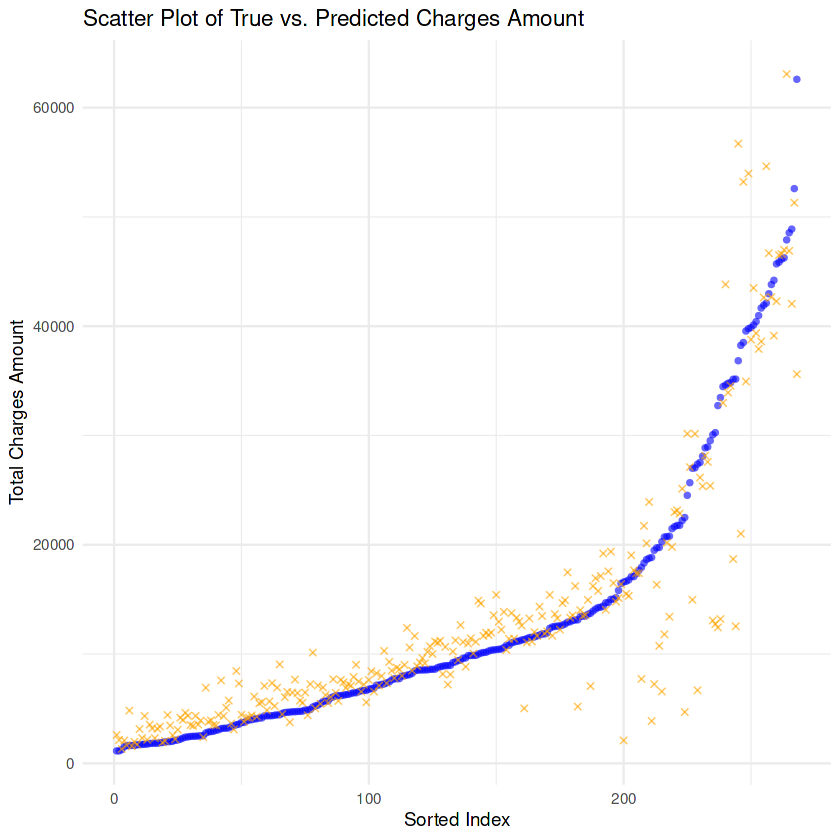

In [13]:
library(ggplot2)

# Create a data frame for plotting
plot_data <- data.frame(
  True_Charges = eval_data$charges,
  Predicted_Charges = preds
)

# Sort by True_Claim for consistent ordering
plot_data <- plot_data[order(plot_data$True_Charges), ]

# Create scatter plot with ggplot2
ggplot() +
  geom_point(data = plot_data, aes(x = 1:nrow(plot_data), y = True_Charges), color = "blue", shape = 16, alpha = 0.6) +
  geom_point(data = plot_data, aes(x = 1:nrow(plot_data), y = Predicted_Charges), color = "orange", shape = 4, alpha = 0.6) +
  labs(x = "Sorted Index", y = "Total Charges Amount") +
  ggtitle("Scatter Plot of True vs. Predicted Charges Amount") +
  theme_minimal()

             Feature         Gain        Cover   Frequency
 1:           smoker 0.5706031625 0.5254273925 0.138823529
 2:              age 0.2699615835 0.3521950701 0.402352941
 3:              bmi 0.0984464339 0.0818964841 0.294117647
 4:       children_0 0.0269133364 0.0142174911 0.042352941
 5:       children_2 0.0093465204 0.0054960824 0.021176471
 6:              sex 0.0062805108 0.0042766714 0.021176471
 7: region_northeast 0.0053207106 0.0037460597 0.018823529
 8:       children_4 0.0046577668 0.0057227504 0.021176471
 9: region_southwest 0.0036515540 0.0036504481 0.018823529
10: region_northwest 0.0030088462 0.0004562547 0.009411765
11:       children_1 0.0013661824 0.0007729558 0.007058824
12: region_southeast 0.0004433925 0.0021423396 0.004705882


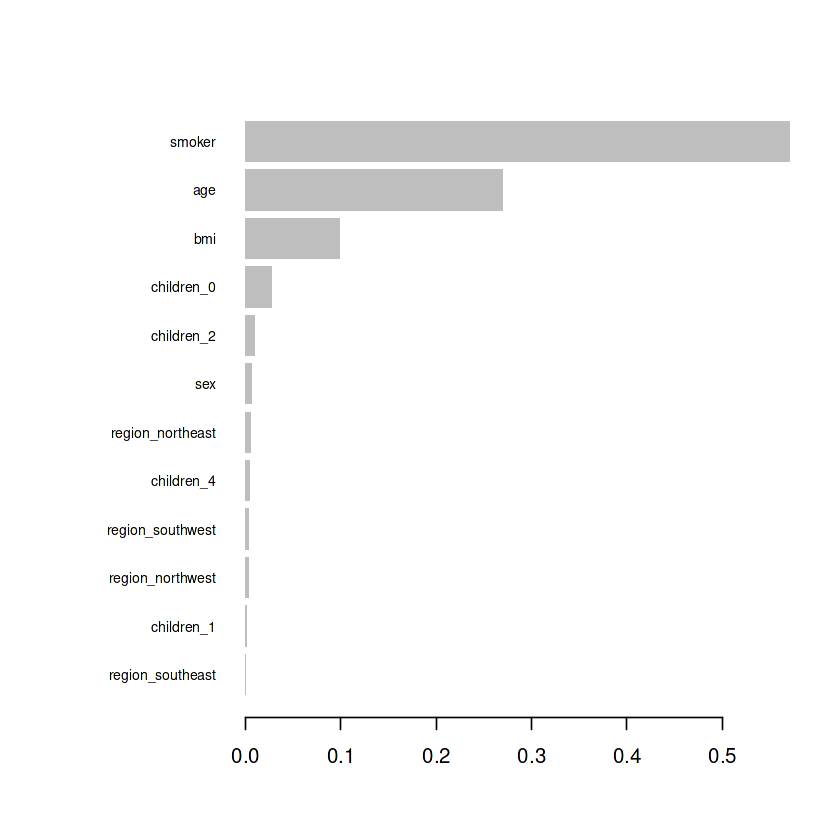

In [14]:
# Get the feature names, excluding the target variable
feature_names <- setdiff(colnames(df), "charges")

# Compute feature importance
importance_matrix <- xgb.importance(feature_names = feature_names, model = best_model)

# Print the feature importance
print(importance_matrix)

# Plot the feature importance
xgb.plot.importance(importance_matrix)